In [4]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Datasets/2payments_rund_10-90.csv', low_memory = False)

In [5]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [23, 21]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [4]:
#bins amount
#transfers: 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [6]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [6]:
#interval that a word corresponds to
#values_map['red']

In [7]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [8]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [9]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [10]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [11]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [12]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [13]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [14]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [15]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [16]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [17]:
#get size of the corpus 
token_count = sum([len(sentence) for sentence in sentences_series])

print("This corpus contains {} tokens".format(token_count))

This corpus contains 36860 tokens


In [29]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, dim, sample, negative, alpha, min_alpha):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = dim,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = sample,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = negative,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = alpha,  #initial learning rate 
        min_alpha = min_alpha,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 5, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

In [38]:
#inicialization, training and creation after grid-search chosen hyperparameters - do not run the first training in running this
import multiprocessing
import gensim.models.word2vec as w2v

def training(sentences):
    model = w2v.Word2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = 2,  #dimension of the embedding space - muda
        window = 1,  #words befores and after the center word - muda
        sample = 0.01,  #whithout subsampling - muda 
        min_count = 1,  #use every word 
        negative = 5,  #noise-words - muda
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = 0.035,  #initial learning rate - muda
        min_alpha = 0.01,  #final learning rate - muda
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training 
    model.train(sentences, epochs = 5, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

#model creation
model = training(sentences_series)

In [39]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1
    
    return 0

In [40]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)

    return predictions

In [41]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [42]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [ ]:
#grid-search
import os
import mlflow
from mlflow import log_metric, log_param, log_artifact
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

#create a hyperparameters dictionary 
dim = [2, 5]    
negative = [5, 10] #0 leads to not having the syn1neg property
alpha = [0.025, 0.035, 0.045] 
min_alpha = [0.0001, 0.001, 0.01, 0.1]  
sample = [0, 0.001, 0.01, 0.1]

#train the model 
i = 0
for d in dim:
    for n in negative:
        for a in alpha:
            for m in min_alpha: 
                for s in sample: 
                    i+=1
                    with mlflow.start_run(nested=True):
                        # Log params to mlflow
                        log_param("dim", d)
                        log_param("negative", n)
                        log_param("alpha", a)
                        log_param("min_alpha", m)
                        log_param("sample", s)

                        curr_model = training(sentences_series_np_train, dim = d, sample = s, negative = n, alpha = a, 
                                              min_alpha = m)

                        #metrics for each combination - train
                        prevs_train = predict(curr_model, sentences_series_np_train, verbose1 = False, verbose2 = False)
                        precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(y_train, prevs_train, average = 'micro')
                        mcc_train = matthews_corrcoef(y_train, prevs_train)
                        g_mean_train = geometric_mean_score(y_train, prevs_train, average = 'micro')
                        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, prevs_train).ravel()

                        log_param("precision_train", precision_train)
                        log_param("recall_train", recall_train)
                        log_param("f1_train", fscore_train)
                        log_param("mcc_train", mcc_train)
                        log_param("g_mean_train", g_mean_train)
                        log_param("tn_train", tn_train)
                        log_param("fp_train", fp_train)
                        log_param("fn_train", fn_train)
                        log_param("tp_train", tp_train)

                        #metrics for each combination - test
                        prevs_test = predict(curr_model, sentences_series_np_test, verbose1 = False, verbose2 = False)
                        precision_test, recall_test, fscore_test, _ = precision_recall_fscore_support(y_test, prevs_test, average = 'micro')
                        mcc_test = matthews_corrcoef(y_test, prevs_test)
                        g_mean_test = geometric_mean_score(y_test, prevs_test, average = 'micro')
                        tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, prevs_test).ravel()

                        log_param("precision_test", precision_test)
                        log_param("recall_test", recall_test)
                        log_param("f1_test", fscore_test)
                        log_param("mcc_test", mcc_test)
                        log_param("g_mean_test", g_mean_test)
                        log_param("tn_test", tn_test)
                        log_param("fp_test", fp_test)
                        log_param("fn_test", fn_test)
                        log_param("tp_test", tp_test)


                        curr_model.save("trained_model.w2v")
                        log_artifact("trained_model.w2v")
                        os.remove("trained_model.w2v")

In [ ]:
#apply the prediction method for the train set
#predict(model, X_train_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values for the train set
#y_train

In [ ]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train
prevs = predict(model, X_train_np.values, verbose1 = False, verbose2 = False, shouldBe = trs)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs,prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

In [ ]:
#apply the prediction method for the test set
#predict(model, X_test_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values of the test set
#set(y_test)

In [43]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_test
prevs = predict(model, X_test_np.values, verbose1 = False, verbose2 = True)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

Transaction: [15, 39, 47, 7833, 1, 7834, 0, 67, 2, 29, 7835, 7, 5, 13, 77, 19, 33, 4]
Fraud prob: 0.0020880421016045148
Non Fraud prob: 0.00208057011514029
Transaction: [9, 3, 72, 7837, 1, 7838, 0, 25, 2, 23, 7839, 7, 5, 13, 81, 19, 32, 4]
Fraud prob: 0.0033576464411453344
Non Fraud prob: 0.003357169931405224
Transaction: [6, 3, 58, 7841, 1, 7842, 0, 21, 2, 23, 7843, 11, 8, 64, 102, 19, 48, 10]
Fraud prob: 0.0032442942238049
Non Fraud prob: 0.0032707653799661784
Transaction: [15, 3, 244, 7845, 1, 7846, 0, 55, 2, 53, 7847, 7, 5, 13, 81, 27, 32, 4]
Fraud prob: 0.002788212106679566
Non Fraud prob: 0.002784611817332916
Transaction: [15, 39, 47, 7849, 1, 7850, 0, 30, 2, 37, 7851, 59, 5, 13, 83, 27, 38, 4]
Fraud prob: 0.0034488919300201815
Non Fraud prob: 0.003441541502979817
Transaction: [9, 3, 229, 7853, 1, 7854, 0, 21, 2, 53, 7855, 60, 5, 14, 121, 24, 43, 4]
Fraud prob: 0.0027028320837416686
Non Fraud prob: 0.002707929968892131
Transaction: [15, 3, 468, 7857, 1, 7858, 0, 30, 2, 37, 7859, 

Transaction: [15, 3, 80, 8027, 1, 8028, 0, 21, 2, 37, 8029, 7, 5, 35, 79, 44, 42, 4]
Fraud prob: 0.0038192377105588093
Non Fraud prob: 0.0038474799366667867
Transaction: [6, 3, 8031, 8032, 1, 8033, 0, 21, 2, 41, 8034, 11, 8, 12, 83, 19, 42, 10]
Fraud prob: 0.002925414314177033
Non Fraud prob: 0.0029467565314007516
Transaction: [15, 129, 47, 124, 51, 8036, 8037, 22, 2, 99, 8038, 7, 5, 13, 125, 27, 48, 4]
Fraud prob: 0.0026354560832260177
Non Fraud prob: 0.0026281568716512993
Transaction: [6, 3, 69, 8040, 1, 8041, 0, 25, 2, 41, 8042, 11, 8, 14, 85, 44, 38, 10]
Fraud prob: 0.0032526082886761287
Non Fraud prob: 0.0032445291162730427
Transaction: [6, 3, 69, 8044, 1, 8045, 0, 25, 2, 54, 8046, 11, 8, 12, 101, 17, 43, 10]
Fraud prob: 0.0023150802626332734
Non Fraud prob: 0.0023213736021716613
Transaction: [9, 28, 8048, 8049, 1, 2695, 0, 22, 2, 53, 8050, 7, 5, 13, 93, 49, 32, 4]
Fraud prob: 0.0023315784310398158
Non Fraud prob: 0.002325399331311928
Transaction: [6, 3, 58, 8052, 1, 8053, 0, 22, 

Transaction: [6, 28, 50, 8226, 1, 8227, 0, 52, 2, 23, 8228, 18, 26, 56, 98, 49, 36, 20]
Fraud prob: 0.002207665591413388
Non Fraud prob: 0.002201581188273849
Transaction: [15, 3, 120, 8230, 1, 8231, 0, 22, 2, 31, 8232, 7, 5, 12, 109, 19, 36, 4]
Fraud prob: 0.0028793307710657245
Non Fraud prob: 0.0029019710918873898
Transaction: [6, 28, 128, 8234, 1, 8235, 0, 22, 2, 70, 8236, 18, 26, 56, 110, 44, 40, 20]
Fraud prob: 0.001993386416870635
Non Fraud prob: 0.001986408395168837
Transaction: [9, 28, 181, 8238, 1, 8239, 0, 22, 2, 29, 8240, 59, 5, 64, 85, 49, 38, 4]
Fraud prob: 0.003240816848119721
Non Fraud prob: 0.0032354232171201147
Transaction: [6, 28, 50, 8242, 51, 8243, 0, 52, 2, 29, 8244, 11, 8, 13, 94, 17, 36, 10]
Fraud prob: 0.0018902316442108713
Non Fraud prob: 0.0018807270607794635
Transaction: [6, 3, 80, 8246, 1, 8247, 0, 30, 2, 29, 8248, 11, 8, 13, 107, 27, 48, 10]
Fraud prob: 0.0019972929349023616
Non Fraud prob: 0.0019952084021497285
Transaction: [15, 3, 8250, 8251, 1, 8252, 0, 7

Transaction: [6, 28, 50, 8432, 1, 8433, 0, 22, 2, 41, 8434, 11, 8, 14, 75, 44, 36, 10]
Fraud prob: 0.0022942095165490173
Non Fraud prob: 0.002303311128343921
Transaction: [9, 3, 198, 8436, 1, 8437, 0, 25, 2, 29, 8438, 7, 5, 14, 93, 16, 32, 4]
Fraud prob: 0.0028381152151268907
Non Fraud prob: 0.002854356302123051
Transaction: [6, 3, 8440, 8441, 1, 8442, 0, 30, 2, 41, 3592, 18, 26, 12, 96, 19, 33, 20]
Fraud prob: 0.0020147728646406904
Non Fraud prob: 0.00200807633518707
Transaction: [9, 3, 458, 8444, 1, 8445, 0, 55, 2, 61, 8446, 7, 5, 13, 154, 27, 62, 4]
Fraud prob: 0.0023601270222570747
Non Fraud prob: 0.002363317209528759
Transaction: [6, 3, 253, 8448, 1, 8449, 0, 25, 2, 31, 8450, 11, 8, 14, 102, 24, 48, 10]
Fraud prob: 0.0024217186255555134
Non Fraud prob: 0.0024146304531313945
Transaction: [6, 3, 8452, 8453, 1, 8454, 0, 25, 2, 41, 8455, 11, 8, 14, 102, 44, 38, 10]
Fraud prob: 0.00294498453149572
Non Fraud prob: 0.0029412861840683036
Transaction: [9, 3, 454, 8457, 1, 8458, 0, 46, 2, 2

Transaction: [6, 3, 80, 8628, 1, 8629, 0, 46, 2, 29, 8630, 11, 8, 35, 83, 16, 42, 10]
Fraud prob: 0.0022646802717645187
Non Fraud prob: 0.0022707196221745107
Transaction: [6, 28, 50, 8632, 1, 8633, 0, 52, 2, 37, 8634, 11, 8, 13, 82, 44, 48, 10]
Fraud prob: 0.002076706190564437
Non Fraud prob: 0.002080865695461398
Transaction: [6, 3, 72, 8636, 1, 8637, 0, 52, 2, 23, 8638, 11, 8, 35, 111, 16, 33, 10]
Fraud prob: 0.0033686579208733747
Non Fraud prob: 0.003362864759765216
Transaction: [9, 127, 148, 8640, 1, 8641, 0, 46, 2, 37, 8642, 7, 5, 13, 94, 24, 43, 4]
Fraud prob: 0.0023349360417341813
Non Fraud prob: 0.0023373263829853386
Transaction: [9, 3, 436, 8644, 1, 8645, 0, 30, 2, 23, 8646, 7, 5, 12, 100, 17, 42, 4]
Fraud prob: 0.005035146436057403
Non Fraud prob: 0.005028500536354841
Transaction: [6, 3, 72, 8648, 1, 8649, 0, 30, 2, 41, 8650, 11, 8, 13, 86, 19, 34, 10]
Fraud prob: 0.0017851295524451416
Non Fraud prob: 0.0017778168730728794
Transaction: [6, 3, 58, 2669, 1, 136, 0, 25, 45, 37, 1

Transaction: [6, 3, 153, 8823, 1, 8824, 0, 22, 2, 31, 8825, 11, 8, 12, 106, 49, 34, 10]
Fraud prob: 0.0022204952492757
Non Fraud prob: 0.0022289677526714513
Transaction: [6, 3, 6008, 8827, 1, 8828, 0, 22, 2, 31, 8829, 11, 8, 14, 83, 44, 42, 10]
Fraud prob: 0.0031269793689716607
Non Fraud prob: 0.0031440403254237026
Transaction: [9, 3, 231, 8831, 1, 8832, 0, 21, 2, 31, 8833, 18, 26, 13, 117, 49, 40, 130]
Fraud prob: 0.0019920932136301417
Non Fraud prob: 0.00199348987734993
Transaction: [6, 28, 50, 8835, 1, 8836, 0, 22, 2, 23, 8837, 18, 26, 12, 94, 24, 43, 20]
Fraud prob: 0.0019259306627645856
Non Fraud prob: 0.0019267575171397766
Transaction: [15, 3, 138, 8839, 1, 8840, 0, 46, 2, 41, 8841, 7, 5, 12, 121, 17, 43, 4]
Fraud prob: 0.0020444701440283097
Non Fraud prob: 0.002037181082414463
Transaction: [6, 3, 229, 8843, 1, 8844, 0, 46, 2, 41, 8845, 11, 8, 14, 92, 17, 40, 10]
Fraud prob: 0.0035268558422103524
Non Fraud prob: 0.0035511129535734653
Transaction: [15, 3, 105, 223, 1, 8847, 0, 74,

Transaction: [9, 39, 57, 9021, 1, 9022, 0, 46, 2, 29, 9023, 7, 5, 12, 82, 16, 34, 4]
Fraud prob: 0.0023786395272509253
Non Fraud prob: 0.0023969848939486837
Transaction: [9, 127, 9025, 9026, 1, 9027, 0, 67, 2, 31, 9028, 59, 5, 12, 101, 27, 43, 4]
Fraud prob: 0.002408299878879916
Non Fraud prob: 0.0024025446182349697
Transaction: [6, 3, 307, 9030, 1, 9031, 0, 46, 2, 41, 9032, 11, 8, 13, 77, 17, 33, 10]
Fraud prob: 0.002484244892912102
Non Fraud prob: 0.00247818053503579
Transaction: [6, 3, 168, 9034, 1, 9035, 0, 22, 2, 54, 9036, 11, 8, 12, 75, 49, 36, 10]
Fraud prob: 0.0018822650326910662
Non Fraud prob: 0.0018831876968761208
Transaction: [15, 3, 65, 9037, 1, 5881, 0, 66, 45, 37, 5882, 7, 5, 13, 63, 24, 40, 4]
Fraud prob: 0.0030472413109237095
Non Fraud prob: 0.003072428333325661
Transaction: [9, 39, 57, 9039, 1, 9040, 0, 30, 2, 37, 9041, 7, 5, 12, 104, 16, 48, 4]
Fraud prob: 0.0025662971536348778
Non Fraud prob: 0.002591895747855233
Transaction: [6, 3, 91, 9043, 51, 9044, 0, 22, 2, 31,

Transaction: [6, 3, 134, 9209, 1, 9210, 0, 30, 2, 29, 9211, 18, 26, 13, 123, 27, 43, 20]
Fraud prob: 0.0017275208665523678
Non Fraud prob: 0.0017235068517038599
Transaction: [6, 3, 114, 9213, 1, 9214, 0, 30, 2, 53, 9215, 11, 8, 13, 117, 24, 40, 10]
Fraud prob: 0.0023104061347112292
Non Fraud prob: 0.002323984454051242
Transaction: [9, 3, 9217, 9218, 1, 9219, 0, 25, 2, 31, 9220, 7, 5, 14, 83, 16, 42, 4]
Fraud prob: 0.0028415228098310763
Non Fraud prob: 0.0028651479606196517
Transaction: [6, 3, 6284, 9222, 1, 9223, 0, 46, 2, 61, 9224, 11, 8, 14, 101, 24, 43, 10]
Fraud prob: 0.00357888822145469
Non Fraud prob: 0.0035734717293962603
Transaction: [9, 3, 176, 9226, 1, 9227, 0, 30, 2, 41, 9228, 7, 5, 13, 123, 24, 43, 4]
Fraud prob: 0.0021309394214767963
Non Fraud prob: 0.002138488125638105
Transaction: [6, 3, 69, 9230, 1, 9231, 0, 25, 2, 41, 9232, 11, 8, 13, 93, 27, 32, 10]
Fraud prob: 0.0033602925468585454
Non Fraud prob: 0.0033838064482552
Transaction: [6, 3, 58, 9233, 1, 6447, 0, 52, 2, 54

Transaction: [6, 3, 9401, 9402, 1, 9403, 0, 21, 2, 53, 9404, 11, 8, 35, 96, 44, 33, 10]
Fraud prob: 0.0025072902244573925
Non Fraud prob: 0.002523902545362944
Transaction: [15, 3, 9406, 9407, 1, 9408, 0, 55, 2, 31, 9409, 7, 5, 64, 82, 19, 34, 4]
Fraud prob: 0.002317110915100784
Non Fraud prob: 0.0023089997830538778
Transaction: [9, 127, 7810, 9411, 1, 9412, 0, 30, 2, 23, 9413, 7, 5, 13, 85, 16, 38, 4]
Fraud prob: 0.0021680224208466825
Non Fraud prob: 0.002187831870287482
Transaction: [6, 28, 50, 9415, 1, 9416, 0, 21, 2, 41, 9417, 11, 8, 35, 110, 16, 40, 10]
Fraud prob: 0.004353974392870441
Non Fraud prob: 0.004352549105533399
Transaction: [6, 39, 57, 9419, 1, 9420, 0, 30, 2, 29, 9421, 11, 8, 14, 121, 27, 43, 10]
Fraud prob: 0.002486045101250056
Non Fraud prob: 0.0025028954332810827
Transaction: [9, 3, 166, 9423, 1, 9424, 0, 25, 2, 29, 9425, 11, 5, 13, 92, 27, 40, 130]
Fraud prob: 0.0018511594462324865
Non Fraud prob: 0.0018506510532461107
Transaction: [9, 3, 2346, 9427, 51, 9428, 0, 25

Transaction: [6, 28, 50, 9613, 1, 9614, 0, 22, 2, 70, 9615, 11, 8, 56, 88, 49, 34, 10]
Fraud prob: 0.0024740938893046405
Non Fraud prob: 0.0024995305498123344
Transaction: [9, 3, 7553, 9617, 1, 9618, 0, 46, 2, 29, 9619, 7, 5, 13, 109, 49, 36, 4]
Fraud prob: 0.0016355520947399782
Non Fraud prob: 0.0016300928418786498
Transaction: [9, 39, 57, 9621, 1, 9622, 0, 25, 2, 137, 9623, 7, 5, 13, 63, 49, 40, 4]
Fraud prob: 0.0025013214981299825
Non Fraud prob: 0.0025110797796514817
Transaction: [9, 127, 253, 9625, 1, 9626, 0, 30, 2, 41, 9627, 7, 8, 13, 109, 24, 36, 20]
Fraud prob: 0.0018741772510111332
Non Fraud prob: 0.001871493790531531
Transaction: [9, 3, 174, 9629, 1, 9630, 0, 25, 2, 41, 9631, 7, 5, 35, 63, 19, 40, 4]
Fraud prob: 0.0029114134335941344
Non Fraud prob: 0.0029395543347163766
Transaction: [6, 3, 4953, 9633, 1, 9634, 0, 22, 2, 54, 9635, 18, 26, 13, 118, 17, 42, 20]
Fraud prob: 0.0017162295407615602
Non Fraud prob: 0.0017123687866842374
Transaction: [9, 3, 91, 9637, 1, 9638, 0, 22,

Transaction: [15, 113, 47, 9801, 1, 9802, 0, 140, 2, 61, 9803, 59, 5, 13, 76, 24, 38, 4]
Fraud prob: 0.0019850021271849982
Non Fraud prob: 0.0019983548918389715
Transaction: [6, 3, 172, 9805, 1, 9806, 0, 22, 2, 41, 9807, 11, 8, 12, 106, 24, 34, 10]
Fraud prob: 0.003452420365647413
Non Fraud prob: 0.003454673438682221
Transaction: [15, 39, 47, 9809, 1, 9810, 0, 133, 2, 37, 9811, 7, 5, 12, 101, 24, 43, 4]
Fraud prob: 0.0018981693056048243
Non Fraud prob: 0.0019060963304582401
Transaction: [6, 28, 50, 9813, 1, 9814, 0, 21, 2, 54, 9815, 18, 26, 56, 98, 24, 36, 20]
Fraud prob: 0.0017128261570178438
Non Fraud prob: 0.00170732163314824
Transaction: [9, 3, 364, 9817, 1, 9818, 0, 30, 2, 41, 9819, 7, 5, 13, 101, 24, 43, 4]
Fraud prob: 0.0027336231360095553
Non Fraud prob: 0.0027443044455139898
Transaction: [15, 3, 65, 218, 1, 208, 0, 66, 45, 53, 201, 7, 5, 13, 63, 16, 40, 4]
Fraud prob: 0.0020314287413611964
Non Fraud prob: 0.002043079775944534
Transaction: [9, 39, 57, 9821, 1, 9822, 0, 21, 2, 2

Transaction: [6, 3, 58, 9998, 1, 9999, 0, 25, 2, 41, 10000, 11, 8, 64, 86, 27, 34, 10]
Fraud prob: 0.0031247923834598623
Non Fraud prob: 0.003144185488054063
Transaction: [9, 28, 10002, 10003, 1, 10004, 0, 22, 2, 54, 10005, 7, 5, 12, 82, 17, 34, 4]
Fraud prob: 0.0029462133898050524
Non Fraud prob: 0.0029525517093134113
Transaction: [6, 3, 72, 10007, 1, 10008, 0, 22, 2, 37, 10009, 11, 8, 12, 85, 19, 38, 10]
Fraud prob: 0.0023268209552043118
Non Fraud prob: 0.002324754575965926
Transaction: [6, 3, 114, 10011, 1, 10012, 0, 25, 2, 23, 10013, 11, 8, 13, 112, 16, 43, 10]
Fraud prob: 0.002416293962596683
Non Fraud prob: 0.0024302628844452556
Transaction: [9, 3, 6789, 10015, 1, 10016, 0, 30, 2, 87, 10017, 7, 5, 13, 116, 27, 42, 4]
Fraud prob: 0.0023243933801495587
Non Fraud prob: 0.0023413459393850644
Transaction: [6, 28, 50, 10019, 1, 10020, 0, 21, 2, 54, 10021, 11, 8, 56, 93, 44, 32, 10]
Fraud prob: 0.0024175706421374343
Non Fraud prob: 0.0024274418537970632
Transaction: [6, 28, 50, 10023, 1

Transaction: [9, 3, 91, 10192, 51, 10193, 0, 22, 2, 70, 10194, 7, 5, 12, 63, 17, 40, 4]
Fraud prob: 0.0021317864952834498
Non Fraud prob: 0.0021240578566903423
Transaction: [141, 39, 47, 10196, 1, 10197, 0, 67, 2, 37, 142, 18, 26, 35, 102, 17, 48, 20]
Fraud prob: 0.0024821943625283893
Non Fraud prob: 0.002504288491763873
Transaction: [15, 113, 47, 10199, 1, 10200, 0, 55, 2, 31, 10201, 7, 5, 14, 116, 19, 42, 4]
Fraud prob: 0.0019776350595748227
Non Fraud prob: 0.0019936348612645816
Transaction: [6, 28, 50, 10203, 1, 10204, 0, 22, 2, 89, 10205, 11, 8, 14, 107, 24, 48, 10]
Fraud prob: 0.0023710554669378325
Non Fraud prob: 0.00237060272047529
Transaction: [6, 28, 128, 10207, 1, 10208, 0, 22, 2, 61, 10209, 11, 8, 13, 116, 16, 42, 10]
Fraud prob: 0.001727588547510095
Non Fraud prob: 0.001722558357869275
Transaction: [15, 39, 47, 10211, 1, 10212, 0, 66, 2, 135, 10213, 95, 5, 12, 147, 17, 62, 4]
Fraud prob: 0.003984697821579175
Non Fraud prob: 0.0039816077005525585
Transaction: [6, 28, 50, 102

Transaction: [15, 129, 47, 124, 1, 10371, 10372, 30, 2, 37, 10373, 7, 5, 12, 79, 27, 42, 4]
Fraud prob: 0.002286180853843689
Non Fraud prob: 0.00229117654816946
Transaction: [9, 39, 57, 10375, 1, 10376, 0, 30, 2, 53, 10377, 95, 5, 14, 109, 27, 36, 4]
Fraud prob: 0.0019475366389087867
Non Fraud prob: 0.001957538737769937
Transaction: [9, 3, 91, 10379, 51, 10380, 0, 21, 2, 41, 10381, 7, 5, 12, 90, 17, 38, 4]
Fraud prob: 0.002095389601890929
Non Fraud prob: 0.002090983522066381
Transaction: [9, 28, 181, 10383, 1, 10384, 0, 22, 2, 53, 10385, 7, 5, 13, 92, 49, 40, 4]
Fraud prob: 0.0018405559931125026
Non Fraud prob: 0.0018486097505956423
Transaction: [6, 3, 10387, 10388, 1, 10389, 0, 21, 2, 54, 10390, 11, 8, 35, 106, 24, 34, 10]
Fraud prob: 0.002959166835353244
Non Fraud prob: 0.0029647379342350177
Transaction: [6, 3, 91, 10392, 1, 10393, 0, 21, 2, 23, 10394, 18, 26, 14, 81, 16, 32, 20]
Fraud prob: 0.0022073436339269392
Non Fraud prob: 0.002216382163169328
Transaction: [9, 3, 8390, 10396, 1

Transaction: [9, 3, 69, 10558, 1, 10559, 0, 25, 2, 23, 10560, 18, 68, 13, 93, 49, 32, 4]
Fraud prob: 0.0018745038687484339
Non Fraud prob: 0.0018709806390688755
Transaction: [15, 3, 163, 10562, 1, 10563, 0, 66, 2, 53, 10564, 7, 5, 14, 104, 27, 48, 4]
Fraud prob: 0.002000560297346965
Non Fraud prob: 0.0019932809891543
Transaction: [6, 28, 50, 10566, 1, 10567, 0, 22, 2, 29, 10568, 18, 26, 12, 107, 17, 48, 20]
Fraud prob: 0.0018282637392985635
Non Fraud prob: 0.0018338687004870735
Transaction: [15, 3, 65, 2268, 1, 10270, 0, 66, 45, 61, 10569, 7, 5, 13, 92, 24, 40, 4]
Fraud prob: 0.0026995531079592183
Non Fraud prob: 0.002718736621318385
Transaction: [9, 3, 8854, 10571, 51, 10572, 0, 21, 2, 41, 10573, 59, 5, 35, 103, 44, 36, 4]
Fraud prob: 0.0016123422146847588
Non Fraud prob: 0.0016042224060583976
Transaction: [9, 28, 181, 10575, 1, 10576, 0, 22, 2, 29, 10577, 7, 5, 12, 167, 16, 62, 4]
Fraud prob: 0.0030455044980044477
Non Fraud prob: 0.0030398962371691596
Transaction: [9, 3, 253, 10579, 

Transaction: [9, 127, 1483, 10747, 1, 10748, 0, 22, 2, 53, 10749, 7, 5, 35, 125, 19, 48, 4]
Fraud prob: 0.004346628051280277
Non Fraud prob: 0.0043427609343780205
Transaction: [6, 3, 72, 10751, 1, 10752, 0, 25, 2, 23, 10753, 11, 8, 12, 102, 19, 48, 10]
Fraud prob: 0.002434203590382822
Non Fraud prob: 0.0024431600177194923
Transaction: [9, 3, 169, 10755, 1, 10756, 0, 30, 2, 41, 10757, 7, 5, 35, 116, 19, 42, 4]
Fraud prob: 0.002774717111606151
Non Fraud prob: 0.0027852652056026272
Transaction: [6, 3, 58, 308, 1, 136, 0, 25, 45, 37, 195, 11, 8, 13, 76, 44, 38, 10]
Fraud prob: 0.0021199554383564134
Non Fraud prob: 0.0021429768010783334
Transaction: [9, 3, 69, 10759, 1, 10760, 0, 30, 2, 53, 10761, 7, 68, 35, 110, 17, 40, 4]
Fraud prob: 0.003050979103136342
Non Fraud prob: 0.0030709965867572464
Transaction: [6, 129, 47, 124, 1, 10763, 10764, 133, 2, 87, 10765, 18, 26, 13, 100, 16, 42, 20]
Fraud prob: 0.001471448802476516
Non Fraud prob: 0.0014643603572039865
Transaction: [6, 3, 80, 10767, 1,

Transaction: [6, 3, 138, 10948, 1, 10949, 0, 21, 2, 41, 10950, 11, 8, 13, 117, 44, 40, 10]
Fraud prob: 0.0018490923066565301
Non Fraud prob: 0.0018453325428708922
Transaction: [9, 3, 8390, 10952, 1, 10953, 0, 67, 2, 87, 327, 7, 8, 13, 123, 17, 43, 20]
Fraud prob: 0.0019248175904067466
Non Fraud prob: 0.001919076950798626
Transaction: [6, 39, 57, 10955, 1, 10956, 0, 74, 2, 31, 10957, 18, 26, 13, 125, 27, 48, 20]
Fraud prob: 0.005927557083850843
Non Fraud prob: 0.005923092447119416
precision: 0.5492788461538461
recall: 0.5492788461538461
fscore: 0.5492788461538461
mcc: 0.0
G-mean: 0.5492788461538461
[[457 375]
 [  0   0]]
true negatives: 457
false positives: 375
false negatives: 0
true positives: 0
specifity: 0.5492788461538461


C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


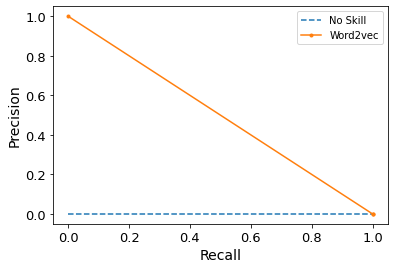

In [46]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
from matplotlib import pyplot as plt

precision, recall, thresholds = precision_recall_curve(trs, prevs)

no_skill = trs.count(1) / len(trs)

#no-skill classifier
pyplot.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
pyplot.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
pyplot.xlabel('Recall', fontsize = 14)
pyplot.ylabel('Precision', fontsize = 14)

#ticks
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

#legend
pyplot.legend()

#save
plt.savefig(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Profiles/prcurve_payments.png')

pyplot.show()